In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
# sys.path.append(os.path.abspath(os.path.join('../utils')))
sys.path.append('../')

import cv2
import time
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from utils.datagenerator import EyeDataset
from metrics import *
from utils.utils import load_image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras_fc_densenet import _create_fc_dense_net, build_FC_DenseNet10

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
# dynamically grow GPU memory
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config))

/home/choppy/anaconda3/envs/alcohol/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/choppy/anaconda3/envs/alcohol/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/choppy/anaconda3/envs/alcohol/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/choppy/anaconda3/envs/alcohol/lib/pyt

In [2]:
def class_mean_iou(pred, label):
    pred = np.argmax(pred, axis=-1)
    label = np.argmax(label, axis=-1)
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels)

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)
    class_iou = []
    
    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))
        class_iou.append(np.mean(I[index] / U[index]))

    dict_class_iou = {
        'bg': class_iou[0],
        'iris': class_iou[2],
        'pupil': class_iou[3],
        'sclera': class_iou[1],
        'miou': np.mean(class_iou),
        'stdiou:': np.std(class_iou)
    }
    
    return dict_class_iou

def mIoU(pred, label, ths=0.5):
    num_unique_labels = label.shape[-1]

    I = np.zeros(num_unique_labels, dtype=np.float32)
    U = np.zeros(num_unique_labels, dtype=np.float32)
    class_iou = np.zeros(num_unique_labels, dtype=np.float32)
    
    for index in range(num_unique_labels):
        mask = np.where(pred[..., index] > ths, 1., 0.)
        
        I[index] = float(np.sum(np.logical_and(label[..., index], mask)))
        U[index] = float(np.sum(np.logical_or(label[..., index], mask)))
        iou = np.mean(I[index] / U[index])
        
        class_iou[index] = iou if not np.isnan(iou) else 0.0

    dict_class_iou = {
        'bg': class_iou[0],
        'iris': class_iou[2],
        'pupil': class_iou[3],
        'sclera': class_iou[1],
        'miou': np.mean(class_iou),
        'stdiou:': np.std(class_iou)
    }
    
    return dict_class_iou

In [3]:
dim = (240, 320)

# dataset contains pupil, iris, sclera and eye marks
dataset_dir = "/home/choppy/TOC/datasets/alcohol/alcohol_v7.0"

# class_map_dir = os.path.join(dataset_dir, "class_dict.csv")

print("[INFO] Loading dataset")

testG = EyeDataset(batch_size=1, dim=dim)
testG.load_eyes(dataset_dir, "test")
testG.prepare()

valG = EyeDataset(batch_size=1, dim=dim)
valG.load_eyes(dataset_dir, "val")
valG.prepare()

# trainG = OpenEDS(batch_size=4, augmentation=None, dim=dim)
# trainG.load_eyes(dataset_dir, "train")
# trainG.prepare()

[INFO] Loading dataset


In [4]:
im, lb = testG[0]
im.shape, lb.shape

((1, 240, 320, 3), (1, 240, 320, 4))

In [5]:
testG.input_shape

(240, 320, 3)

In [6]:
model = build_FC_DenseNet10(
    # nb_classes=testG.num_classes, 
    nb_classes=4,
    final_softmax=True, 
    input_shape=testG.input_shape

)

# openeds_modelpath = '../models/epoch_124_miou_0.9345.h5'
modelpath = '/home/choppy/TOC/densenet10/models/weights/dense_models/blurry_gemini_dense_miou_0.9275.h5'

model.load_weights(modelpath)

INFO:tensorflow:Layers in each dense block: [3, 3, 3, 3, 3, 3, 3, 3, 3]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Number of skip connections: 4


# Model Info

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 240, 320, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 320, 48) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_norm

In [8]:
f'{model.count_params():,}'

'210,732'

# Pred one image

((240, 320, 4), (1, 240, 320, 3))

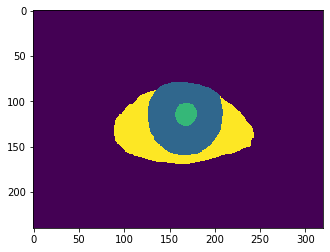

In [9]:
im, lb = testG[0]
pred = model.predict(im)[0]
plt.imshow(np.argmax(pred, axis=-1))
pred.shape, im.shape

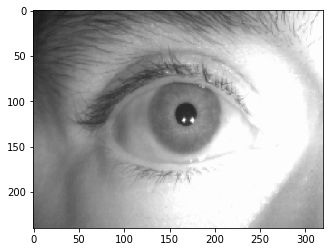

In [10]:
plt.imshow(im[0, ...])

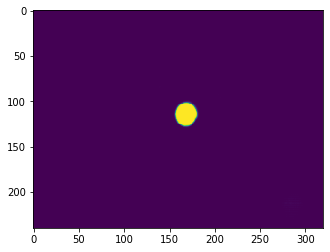

In [11]:
plt.imshow(pred[..., 2]) # choose between 0-1-2-3 classes

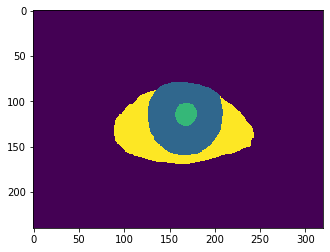

In [12]:
plt.imshow(np.argmax(pred, axis=-1)) # show all classes

# Evaluate final IoU of test set

In [13]:
val_iou = []

for i in tqdm(range(len(testG)), desc='test set'):
    fname = testG.image_info[i]['path']
    im, lb = testG[i]
    start = time.time()
    output_image = model.predict(im)[0]
    end = time.time()
    iou = mIoU(output_image, lb[0, ...])
    val_iou.append({
        'fname': fname,
        'miou': iou['miou'],
        'inf_time': end-start,
        '_classes': {
            'bg': iou['bg'],
            'iris': iou['iris'],
            'pupil': iou['pupil'],
            'sclera': iou['sclera']
        },
    })

miou = np.mean([elem['miou'] for elem in val_iou])
std_iou = np.std([elem['miou'] for elem in val_iou])
iou_bg = np.mean([elem['_classes']['bg'] for elem in val_iou])
iou_iris = np.mean([elem['_classes']['iris'] for elem in val_iou])
iou_pupil = np.mean([elem['_classes']['pupil'] for elem in val_iou])
iou_sclera = np.mean([elem['_classes']['sclera'] for elem in val_iou])

print(f'mean iou: {miou}')
print(f'std iou: {std_iou}')
print(f'miou bg: {iou_bg}')
print(f'miou iris: {iou_iris}')
print(f'miou pupil: {iou_pupil}')
print(f'miou sclera: {iou_sclera}')

test set: 100%|██████████| 2132/2132 [01:10<00:00, 30.06it/s]

mean iou: 0.9019728302955627
std iou: 0.05893946811556816
miou bg: 0.9849934577941895
miou iris: 0.916151762008667
miou pupil: 0.787741482257843
miou sclera: 0.9190046787261963
